In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
import matplotlib.axes as axes

/var/folders/pc/2vy016913bs5kzpn254yq_f40000gn/T/ipykernel_80330/2672773785.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
inter_arrival_time = 1.0
op_time = inter_arrival_time/1000
target_utilization = 0.8
k_servers: int = 10
processing_time = inter_arrival_time * k_servers * target_utilization
gamma_shape = 9.0

n_jobs: int = 10000
sampling_target: float = 5.0
simulation_factor: float = 100.0

sampling_period = int(inter_arrival_time * sampling_target)
time_limit = int(inter_arrival_time * n_jobs + target_utilization/(1-target_utilization)*inter_arrival_time*simulation_factor)
jobs_limit = round(time_limit/inter_arrival_time)

jobs_limit

def exponential(scale: float):
  return lambda nsamples : np.random.exponential(scale, nsamples)

def parametrized_gamma(samples: int):
  return np.random.gamma(gamma_shape, processing_time/gamma_shape, samples)

arrival_distribution = exponential(inter_arrival_time)
processing_distribution = parametrized_gamma


In [3]:
inter_arrivals: list[float] = arrival_distribution(n_jobs-1)
processing_times: list[float] = processing_distribution(n_jobs)
##arrival_times = [ sum(inter_arrivals[0:idx]) for idx in range(0, n_jobs+1) ]

arrival_times = [0]
for idx in range(0, n_jobs-1):
  arrival_times.append(arrival_times[idx]+inter_arrivals[idx])


In [4]:
jobs = pd.DataFrame([ [arrival_times[idx], processing_times[idx], 0.0, 0.0] for idx in range(0, n_jobs)], columns = ["Arrival", "Processing", "Start", "Complete"])

In [5]:

for idx in range(0, n_jobs):
  simNow = jobs['Arrival'][idx]
  jobs.loc[idx, 'Arrived'] = int(idx+1)
  if(idx == 0):
    jobs.loc[idx, 'Start'] = jobs['Arrival'][idx]+op_time
    jobs.loc[idx, 'Complete'] = jobs['Start'][idx] + jobs['Processing'][idx]+op_time
    jobs.loc[idx, 'Busy'] = 1
  else:
    pending = jobs[(jobs['Complete'] > simNow+op_time) & (jobs['Arrival'] <= simNow)].sort_values('Complete')
    jobs.loc[idx, 'Pending'] = len(pending.index)
    first_free = simNow if (len(pending.index) < k_servers) else pending[-k_servers:]['Complete'].values[0]
    start_wip = pending[pending['Start'] <= simNow+op_time]
    start_busy = len(start_wip.index)
    jobs.loc[idx, 'Start'] = first_free+op_time
    will_complete = jobs['Start'][idx] + jobs['Processing'][idx]
    jobs.loc[idx, 'Complete'] = will_complete
    jobs.loc[idx, 'Busy'] = start_busy + 1 if (start_busy < k_servers) else start_busy
    jobs.loc[idx, 'Completed'] = len(jobs[(jobs['Complete'] < will_complete) & (jobs['Complete'] > 0.0)].index)


In [6]:
jobs['Id'] = jobs.index

arrivals = jobs[['Id', 'Arrival']].rename(columns={'Arrival': 'Timestamp'})
arrivals['Event'] = pd.Series(['ARRIVAL' for i in range(0, n_jobs)])

starts = jobs[['Id', 'Start']].rename(columns={'Start': 'Timestamp'})
starts['Event'] = pd.Series(['START' for i in range(0, n_jobs)])

completes = jobs[['Id', 'Complete']].rename(columns={'Complete': 'Timestamp'})
completes['Event'] = pd.Series(['COMPLETE' for i in range(0, n_jobs)])

events = pd.concat([arrivals, starts, completes]).sort_values('Timestamp').reset_index()[['Id', 'Timestamp', 'Event']]

In [7]:
busy_time = completes['Timestamp'] - starts['Timestamp']
(busy_time.mean(), busy_time.std())

(7.9911513031000005, 2.618484257051279)

In [18]:
lead_time = completes['Timestamp'] - arrivals['Timestamp']
(lead_time.mean(), lead_time.std())

(9.12646607004506, 3.3809019798070272)

In [17]:
wait_time = starts['Timestamp'] - arrivals['Timestamp']
(wait_time.mean(), wait_time.std())

(1.1353147669450603, 2.1566072635628757)

In [10]:
total_time = max(completes['Timestamp'])

utilization = sum(busy_time)/(total_time*k_servers)

(total_time, utilization)

(9954.378135188179, 0.8027775512014863)

In [11]:
time_bins = [idx*sampling_target for idx in range(0, round(total_time/sampling_target)+2)]

arrival_counts = pd.DataFrame(arrivals.groupby(pd.cut(arrivals['Timestamp'], time_bins), observed=True).size(), columns=['count'])
completion_counts = pd.DataFrame(completes.groupby(pd.cut(completes['Timestamp'], time_bins), observed=True).size(), columns=['count'])
start_counts =  pd.DataFrame(starts.groupby(pd.cut(starts['Timestamp'], time_bins), observed=True).size(), columns=['count'])


In [12]:
events['wip_change'] = events['Event'].apply(lambda ev: 1 if ev == 'ARRIVAL' else -1 if ev == 'COMPLETE' else 0)
events['busy_change'] = events['Event'].apply(lambda ev: 1 if ev == 'START' else -1 if ev == 'COMPLETE' else 0)
events['wip'] = events['wip_change'].cumsum()
events['busy'] = events['busy_change'].cumsum()

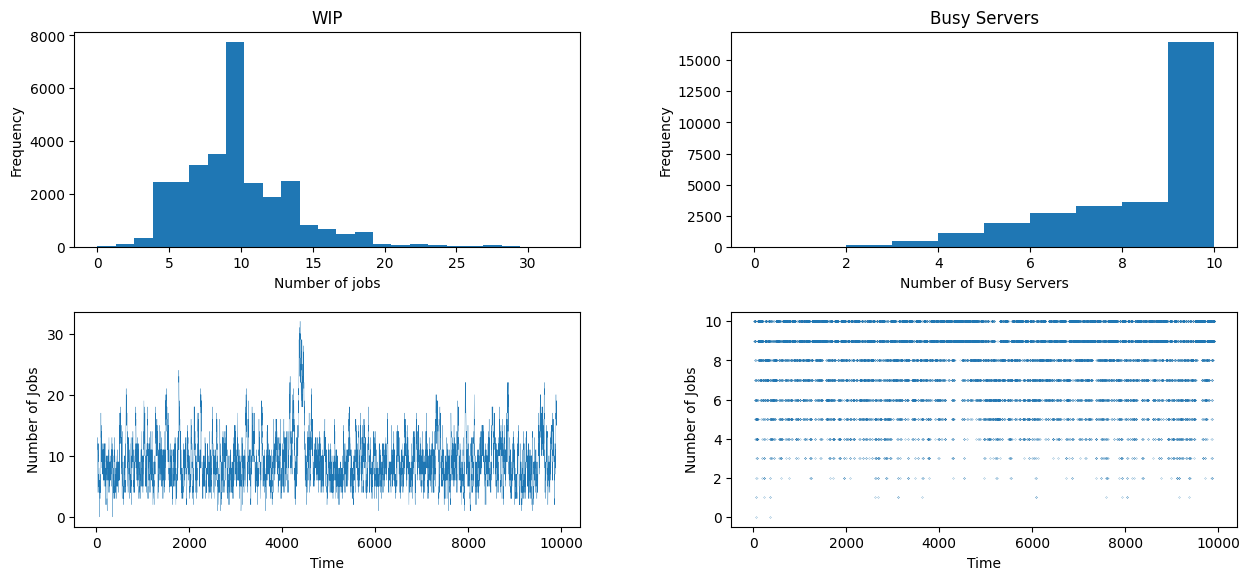

In [21]:
subset = events[100:-100]
markersize = 0.1
linewidth = 0.2
bins = 25

fig, ((tl, tr), (bl, br)) = plot.subplots(nrows=2, ncols=2, figsize=(15, 5))
plot.subplots_adjust(top = 1.0, bottom=0.01, hspace=0.3, wspace=0.3)


#customer_counts.plot.bar(title="Unique Active Customers", ax = axes[0][0])

#events[['Timestamp', 'wip', 'busy']].plot.bar(x='Timestamp')
tl.hist(subset['wip'], bins=bins)
tl.set_xlabel("Number of jobs")
tl.set_ylabel("Frequency")
bl.plot(subset['Timestamp'], subset['wip'], markersize=markersize, linewidth=linewidth)
bl.set_xlabel("Time")
bl.set_ylabel("Number of Jobs")
tl.set_title("WIP")
tr.hist(subset['busy'], bins=k_servers)
tr.set_title("Busy Servers")
tr.set_xlabel("Number of Busy Servers")
tr.set_ylabel("Frequency")
br.plot(subset['Timestamp'], subset['busy'], 'o', markersize=markersize, linewidth=linewidth)
br.set_xlabel("Time")
br.set_ylabel("Number of Jobs")


plot.show()



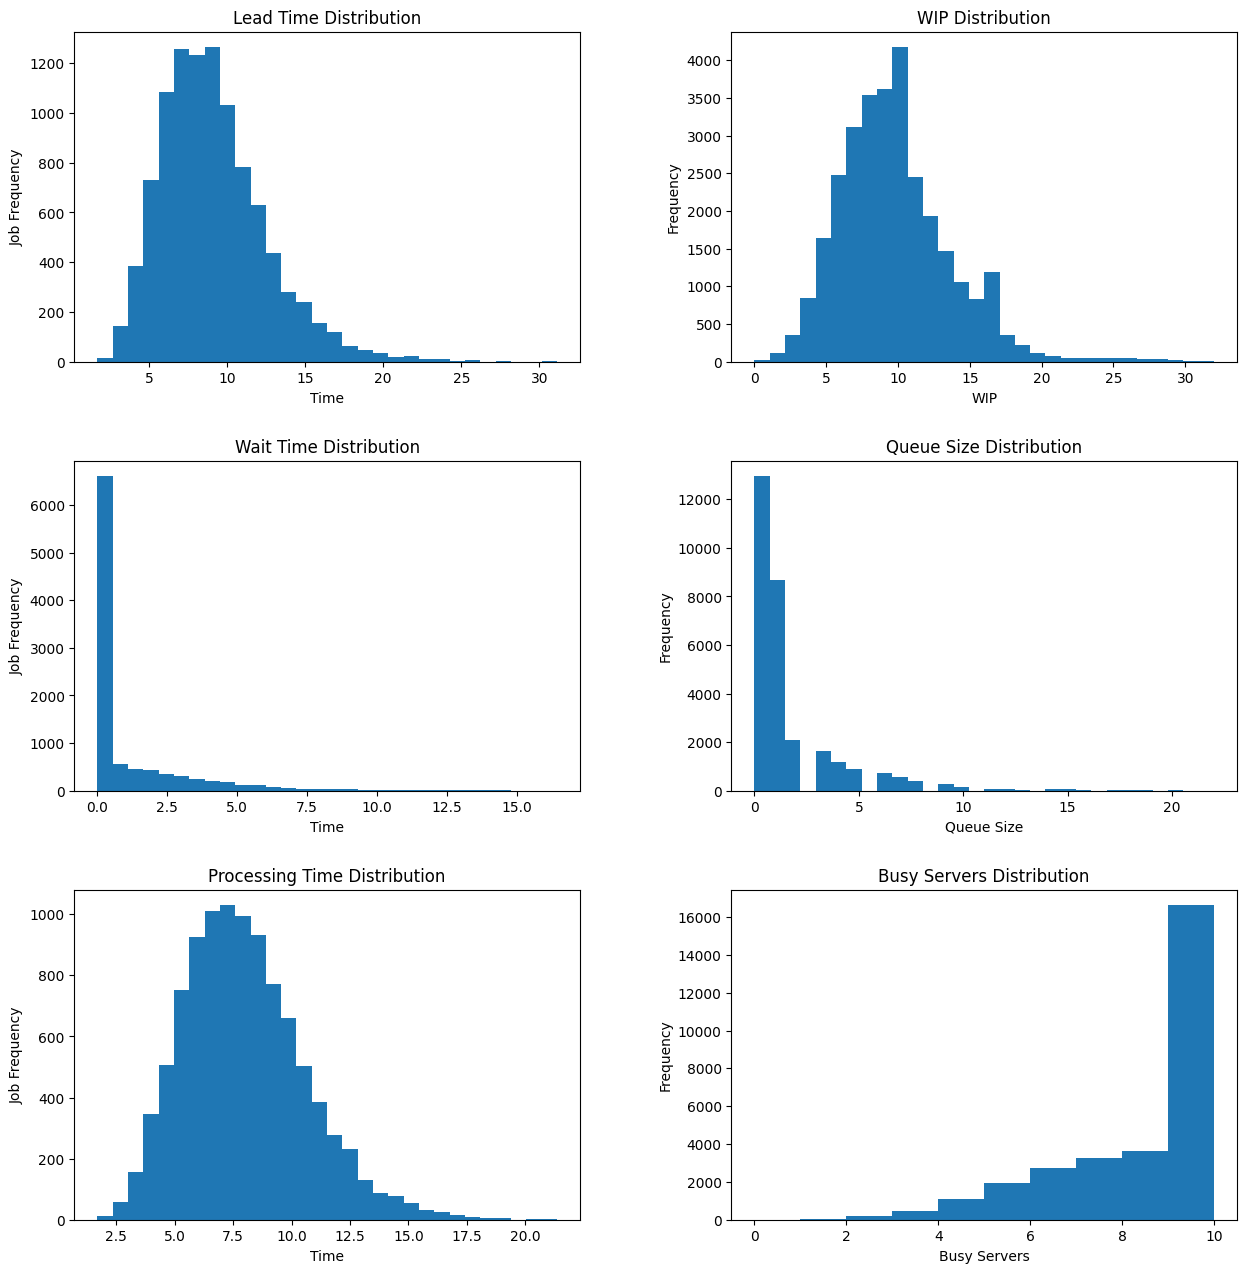

In [22]:
subset = events
markersize = 0.1
linewidth = 0.2
bins = 30

fig, ((tl, tr), (ml, mr), (bl, br)) = plot.subplots(nrows=3, ncols=2, figsize=(15, 12))
plot.subplots_adjust(top = 1.0, bottom=0.01, hspace=0.3, wspace=0.3)

tl.hist(lead_time, bins=bins)
tl.set_title('Lead Time Distribution')
tl.set_xlabel('Time')
tl.set_ylabel('Job Frequency')

tr.hist(subset['wip'], bins=bins)
tr.set_title('WIP Distribution')
tr.set_xlabel('WIP')
tr.set_ylabel('Frequency')

ml.hist(wait_time, bins=bins)
ml.set_title('Wait Time Distribution')
ml.set_xlabel('Time')
ml.set_ylabel('Job Frequency')

mr.hist(subset['wip']-subset['busy'], bins=bins)
mr.set_title('Queue Size Distribution')
mr.set_xlabel('Queue Size')
mr.set_ylabel('Frequency')

bl.hist(busy_time, bins=bins)
bl.set_title('Processing Time Distribution')
bl.set_xlabel('Time')
bl.set_ylabel('Job Frequency')

br.hist(subset['busy'], bins=k_servers)
br.set_title('Busy Servers Distribution')
br.set_xlabel('Busy Servers')
br.set_ylabel('Frequency')


plot.show()


In [15]:
events

,Id,Timestamp,Event,wip_change,busy_change,wip,busy
0,0,0.000000,ARRIVAL,1,0,1,0
1,0,0.001000,START,0,1,1,1
2,1,0.143954,ARRIVAL,1,0,2,1
3,1,0.144954,START,0,1,2,2
4,2,3.260838,ARRIVAL,1,0,3,2
...,...,...,...,...,...,...,...
29995,9995,9950.312004,COMPLETE,-1,-1,4,4
29996,9992,9950.937170,COMPLETE,-1,-1,3,3
29997,9997,9952.446144,COMPLETE,-1,-1,2,2
29998,9998,9953.826383,COMPLETE,-1,-1,1,1


Text(0, 0.5, 'Count per ~10 time units')

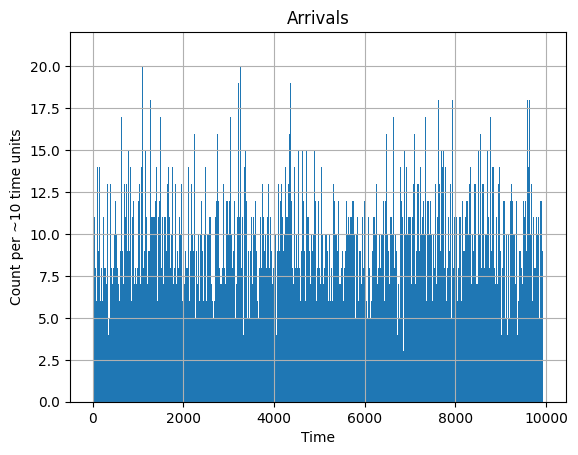

In [16]:
bins = 1000
arrivals.hist('Timestamp', bins=bins)
plot.title("Arrivals")
plot.xlabel("Time")
plot.ylabel(f"Count per ~{round(total_time/bins)} time units")
